# Bayesian performance analysis example in pyfolio

There are also a few more advanced (and still experimental) analysis methods in pyfolio based on Bayesian statistics. 

The main benefit of these methods is **uncertainty quantification**. All the values you saw above, like the Sharpe ratio, are just single numbers. These estimates are noisy because they have been computed over a limited number of data points. So how much can you trust these numbers? You don't know because there is no sense of uncertainty. That is where Bayesian statistics helps as instead of single values, we are dealing with probability distributions that assign degrees of belief to all possible parameter values.

Lets create the Bayesian tear sheet. Under the hood this is running MCMC sampling in [`PyMC3`](http://pymc-devs.github.io/pymc3/) to estimate the posteriors which can take quite a while (that's the reason why we don't generate this by default in `create_full_tear_sheet()`).

# Import pyfolio

In [1]:
%matplotlib inline
import pyfolio as pf

## Fetch the daily returns for a stock

In [2]:
stock_rets = pf.utils.get_symbol_rets('FB')

## Create Bayesian tear sheet



In [3]:
out_of_sample = stock_rets.index[-40]

In [4]:
pf.create_bayesian_tear_sheet(stock_rets, live_start_date=out_of_sample)

Running T model


NameError: global name 'bayesian' is not defined

Lets go through these row by row:

* The first one is the Bayesian cone plot that is the result of a summer internship project of Sepideh Sadeghi here at Quantopian. It's similar to the cone plot you already saw in the tear sheet above but has two critical additions: (i) it takes uncertainty into account (i.e. a short backtest length will result in a wider cone), and (ii) it does not assume normality of returns but instead uses a [Student-T distribution](https://en.wikipedia.org/wiki/Student%27s_t-distribution) with heavier tails.
* The next row compares mean returns of the in-sample (backest) and out-of-sample or OOS (forward) period. As you can see, mean returns are not a single number but a (posterior) distribution that gives us an indication of how certain we can be in our estimates. The green distribution on the left side is much wider, representing our increased uncertainty due to having less OOS data. We can then calculate the difference between these two distributions as shown on the right side. The grey lines denote the 2.5% and 97.5% percentiles. Intuitively, if the right grey line is lower than 0 you can say that with probability > 97.5% the OOS mean returns are below what is suggested by the backtest. The model used here is called [BEST](http://www.indiana.edu/~kruschke/BEST/BEST.pdf) and was developed by John Kruschke.
* The next couple of rows follow the same pattern but are an estimate of annual volatility, Sharpe ratio and their respective differences.
* The 5th row shows the effect size or the difference of means normalized by the standard deviation and gives you a general sense how far apart the two distributions are. Intuitively, even if the means are significantly different, it may not be very meaningful if the standard deviation is huge amounting to a tiny difference of the two returns distributions.
* The 6th row shows predicted returns (based on the backtest) for tomorrow, and 5 days from now. The blue line indicates the probability of losing more than 5% of your portfolio value and can be interpeted as a Bayesian VaR estimate.
* The 7th row shows a Bayesian estimate of annual alpha and beta. In addition to uncertainty estimates, this model, like all above ones, assumes returns to be T-distributed which leads to more robust estimates than a standard linear regression would.  The default benchmark is the S&P500.  Alternatively, users may use the Fama-French model as a bunchmark by setting benchmark_rets="Fama-French".  
* By default, stoch_vol=False because running the stochastic volatility model is computationally expensive.
* Only the most recent 400 days of returns are used when computing the stochastic volatility model.  This is to minimize computational time.

## Running models directly

You can also run individual models. All models can be found in `pyfolio.bayesian` and run via the `run_model()` function.

In [5]:
help(pf.bayesian.run_model)

Help on function run_model in module pyfolio.bayesian:

run_model(model, returns_train, returns_test=None, bmark=None, samples=500, ppc=False)
    Run one of the Bayesian models.
    
    Parameters
    ----------
    model : {'alpha_beta', 't', 'normal', 'best'}
        Which model to run
    returns_train : pd.Series
        Timeseries of simple returns
    returns_test : pd.Series (optional)
        Out-of-sample returns. Datetimes in returns_test will be added to
        returns_train as missing values and predictions will be generated
        for them.
    bmark : pd.Series or pd.DataFrame (optional)
        Only used for alpha_beta to estimate regression coefficients.
        If bmark has more recent returns than returns_train, these dates
        will be treated as missing values and predictions will be
        generated for them taking market correlations into account.
    samples : int (optional)
        Number of posterior samples to draw.
    ppc : boolean (optional)
       

For example, to run a model that assumes returns to be normally distributed, you can call:

In [6]:
# Run model that assumes returns to be T-distributed
trace = pf.bayesian.run_model('t', stock_rets)

Applied log-transform to volatility and added transformed volatility_log to model.
Applied log-transform to nu_minus_two and added transformed nu_minus_two_log to model.
 [-----------------100%-----------------] 500 of 500 complete in 1.9 sec

The returned trace object can be directly inquired. For example might we ask what the probability of the Sharpe ratio being larger than 0 is by checking what percentage of posterior samples of the Sharpe ratio are > 0:

In [7]:
# Check what frequency of samples from the sharpe posterior are above 0.
print('Probability of Sharpe ratio > 0 = {:3}%'.format((trace['sharpe'] > 0).mean() * 100))

Probability of Sharpe ratio > 0 = 92.0%


But we can also interact with it like with any other `pymc3` trace:

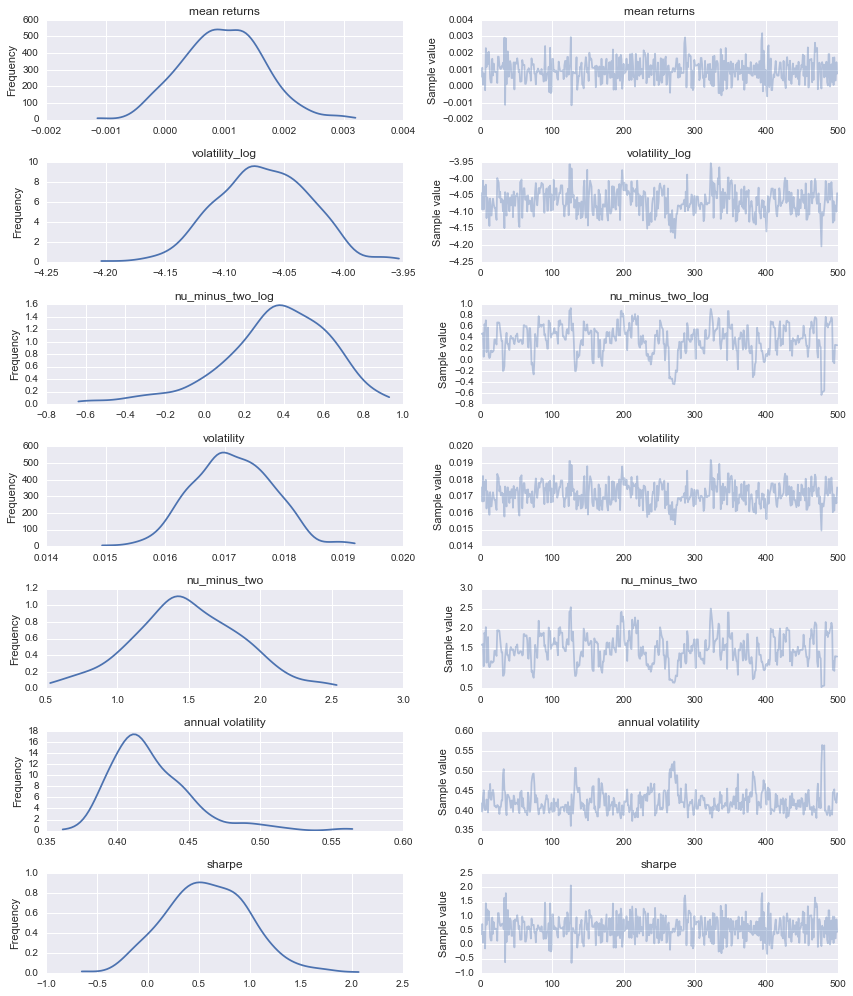

In [8]:
import pymc3 as pm
pm.traceplot(trace);

## Further reading

For more information on Bayesian statistics, check out these resources:

* [A blog post about the Bayesian models with Sepideh Sadeghi](http://blog.quantopian.com/bayesian-cone/)
* [My personal blog on Bayesian modeling](http://twiecki.github.io/)
* A talk I gave in Singapore on [Probabilistic Programming in Quantitative Finance]( http://blog.quantopian.com/probabilistic-programming-for-non-statisticians/)
* The IPython NB book [Bayesian Methods for Hackers](https://github.com/CamDavidsonPilon/Probabilistic-Programming-and-Bayesian-Methods-for-Hackers).